# Disaster Tweets NLP Analysis

This notebook analyzes the Kaggle NLP Getting Started competition dataset.

**Goal**: Predict which tweets are about real disasters and which ones are not.

## Dataset
- `train.csv`: Training set with labels
- `test.csv`: Test set without labels
- `sample_submission.csv`: Sample submission format

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text processing
import re
import string
from collections import Counter

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Settings
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

In [27]:
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"\nFirst few rows of training data:")
train_df[:100]

Training set shape: (7613, 5)
Test set shape: (3263, 4)

First few rows of training data:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...
95,137,accident,Charlotte,9 Mile backup on I-77 South...accident blocking the Right 2 Lanes at Exit 31 Langtree Rd...consider NC 115 or NC 150 to NC 16 as alternate,1
96,138,accident,"Baton Rouge, LA",Has an accident changed your life? We will help you determine options that can financially support life care plans and on-going treatment.,0
97,139,accident,"Hagerstown, MD",#BREAKING: there was a deadly motorcycle car accident that happened to #Hagerstown today. I'll have more details at 5 @Your4State. #WHAG,1
98,141,accident,"Gloucestershire , UK",@flowri were you marinading it or was it an accident?,0


## 3. Data Overview

In [4]:
# Basic information
print("Training Data Info:")
print(train_df.info())
print("\n" + "="*50 + "\n")

# Check for missing values
print("Missing values in training set:")
print(train_df.isnull().sum())
print(f"\nMissing value percentages:")
print((train_df.isnull().sum() / len(train_df) * 100).round(2))

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


Missing values in training set:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing value percentages:
id           0.00
keyword      0.80
location    33.27
text         0.00
target       0.00
dtype: float64


Target distribution:
target
0    4342
1    3271
Name: count, dtype: int64

Percentage:
target
0    57.034021
1    42.965979
Name: proportion, dtype: float64


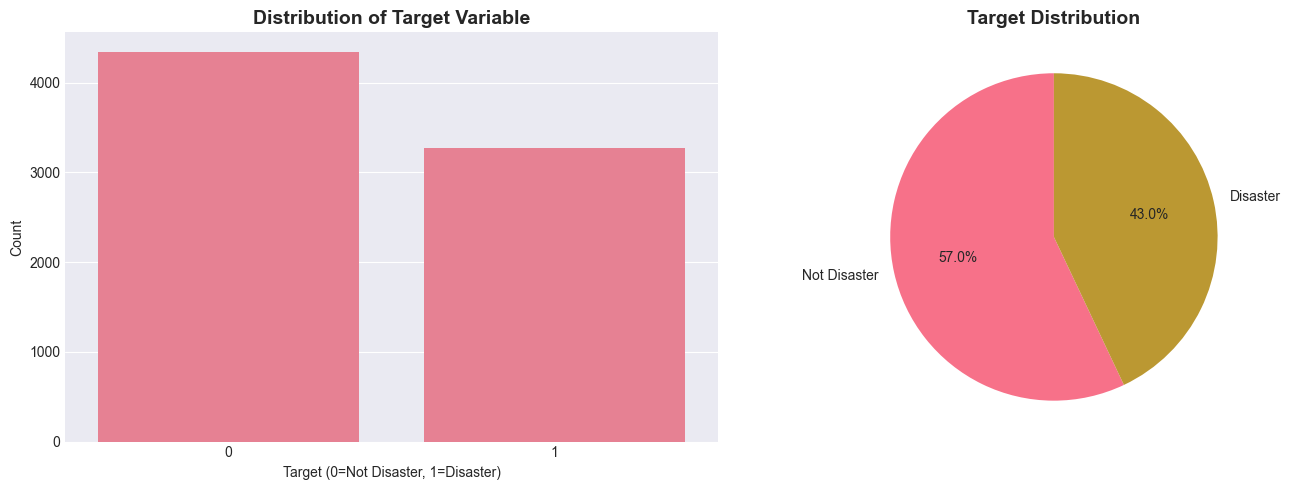

In [5]:
# Target distribution
print("Target distribution:")
print(train_df['target'].value_counts())
print(f"\nPercentage:")
print(train_df['target'].value_counts(normalize=True) * 100)

# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=train_df, x='target', ax=axes[0])
axes[0].set_title('Distribution of Target Variable', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Target (0=Not Disaster, 1=Disaster)')
axes[0].set_ylabel('Count')

# Pie chart
target_counts = train_df['target'].value_counts()
axes[1].pie(target_counts, labels=['Not Disaster', 'Disaster'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Target Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Text Analysis

In [6]:
# Text length analysis
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))

print("Text length statistics:")
print(train_df.groupby('target')[['text_length', 'word_count']].describe())

Text length statistics:
       text_length                                                          \
             count        mean        std   min   25%    50%    75%    max   
target                                                                       
0           4342.0   95.706817  35.885924   7.0  68.0  101.0  130.0  157.0   
1           3271.0  108.113421  29.309854  14.0  88.0  115.0  136.0  151.0   

       word_count                                                    
            count       mean       std  min   25%   50%   75%   max  
target                                                               
0          4342.0  14.704744  6.161564  1.0  10.0  15.0  19.0  31.0  
1          3271.0  15.167533  5.096806  2.0  11.0  15.0  19.0  30.0  


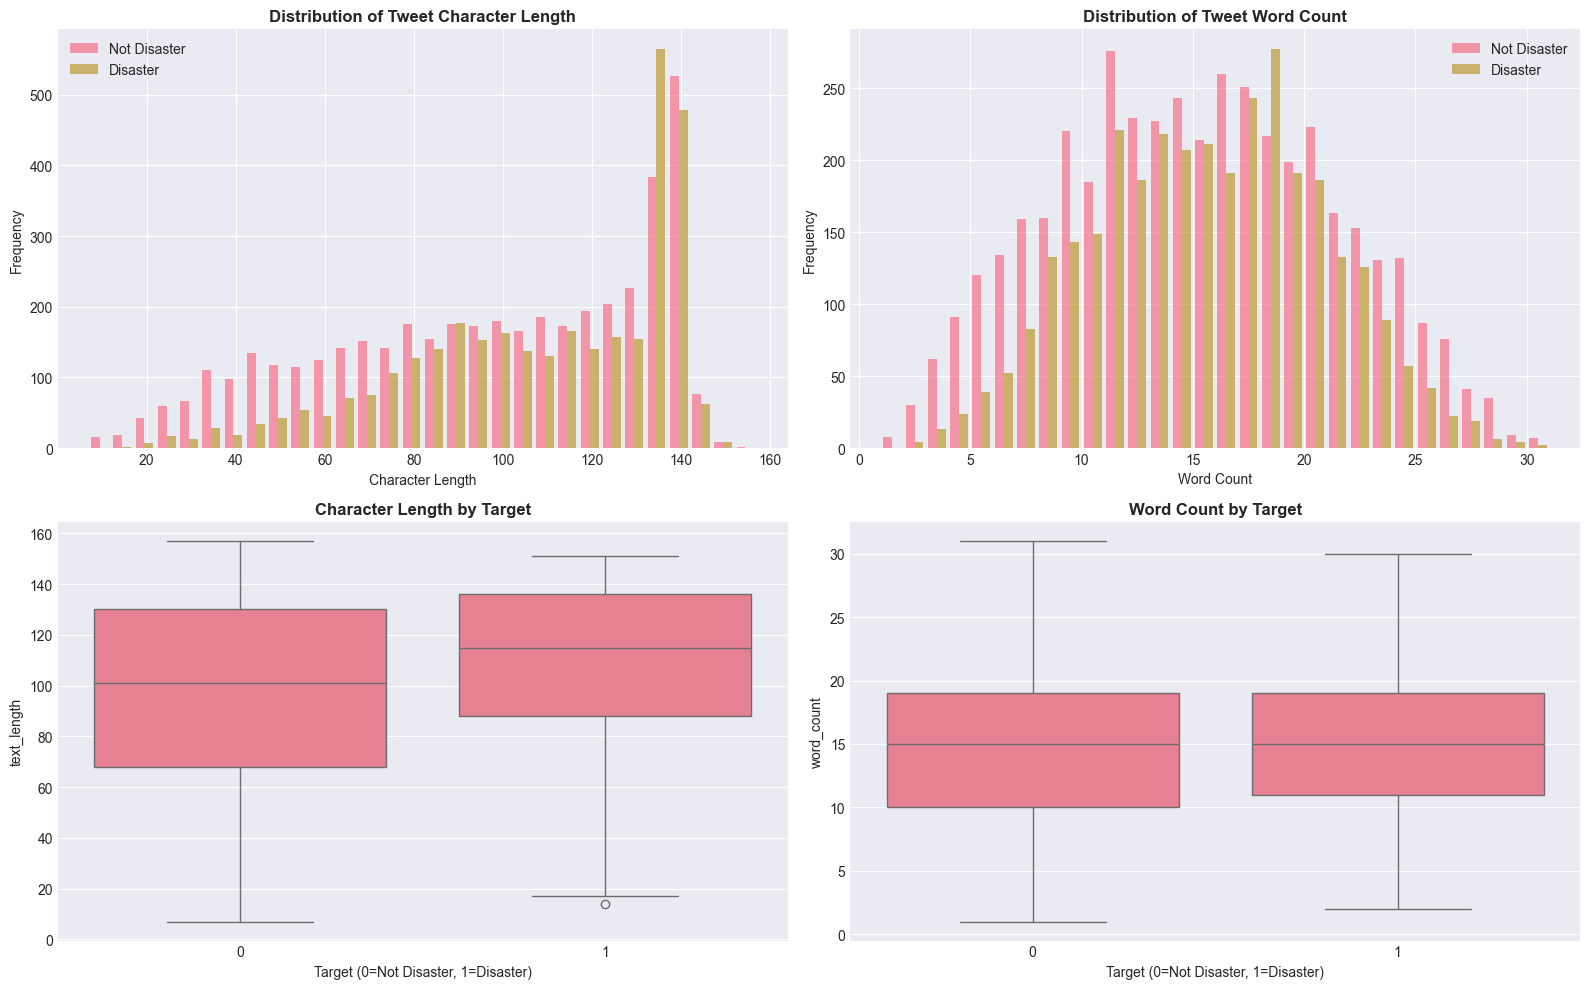

In [7]:
# Visualize text length distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Character length by target
axes[0, 0].hist([train_df[train_df['target']==0]['text_length'], 
                 train_df[train_df['target']==1]['text_length']], 
                label=['Not Disaster', 'Disaster'], bins=30, alpha=0.7)
axes[0, 0].set_xlabel('Character Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Tweet Character Length', fontweight='bold')
axes[0, 0].legend()

# Word count by target
axes[0, 1].hist([train_df[train_df['target']==0]['word_count'], 
                 train_df[train_df['target']==1]['word_count']], 
                label=['Not Disaster', 'Disaster'], bins=30, alpha=0.7)
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Tweet Word Count', fontweight='bold')
axes[0, 1].legend()

# Box plot - character length
sns.boxplot(data=train_df, x='target', y='text_length', ax=axes[1, 0])
axes[1, 0].set_title('Character Length by Target', fontweight='bold')
axes[1, 0].set_xlabel('Target (0=Not Disaster, 1=Disaster)')

# Box plot - word count
sns.boxplot(data=train_df, x='target', y='word_count', ax=axes[1, 1])
axes[1, 1].set_title('Word Count by Target', fontweight='bold')
axes[1, 1].set_xlabel('Target (0=Not Disaster, 1=Disaster)')

plt.tight_layout()
plt.show()

In [8]:
# Analyze keyword and location columns
print("Unique keywords:", train_df['keyword'].nunique())
print("Unique locations:", train_df['location'].nunique())

print("\nTop 10 keywords:")
print(train_df['keyword'].value_counts().head(10))

print("\nTop 10 locations:")
print(train_df['location'].value_counts().head(10))

Unique keywords: 221
Unique locations: 3341

Top 10 keywords:
keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
Name: count, dtype: int64

Top 10 locations:
location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: count, dtype: int64


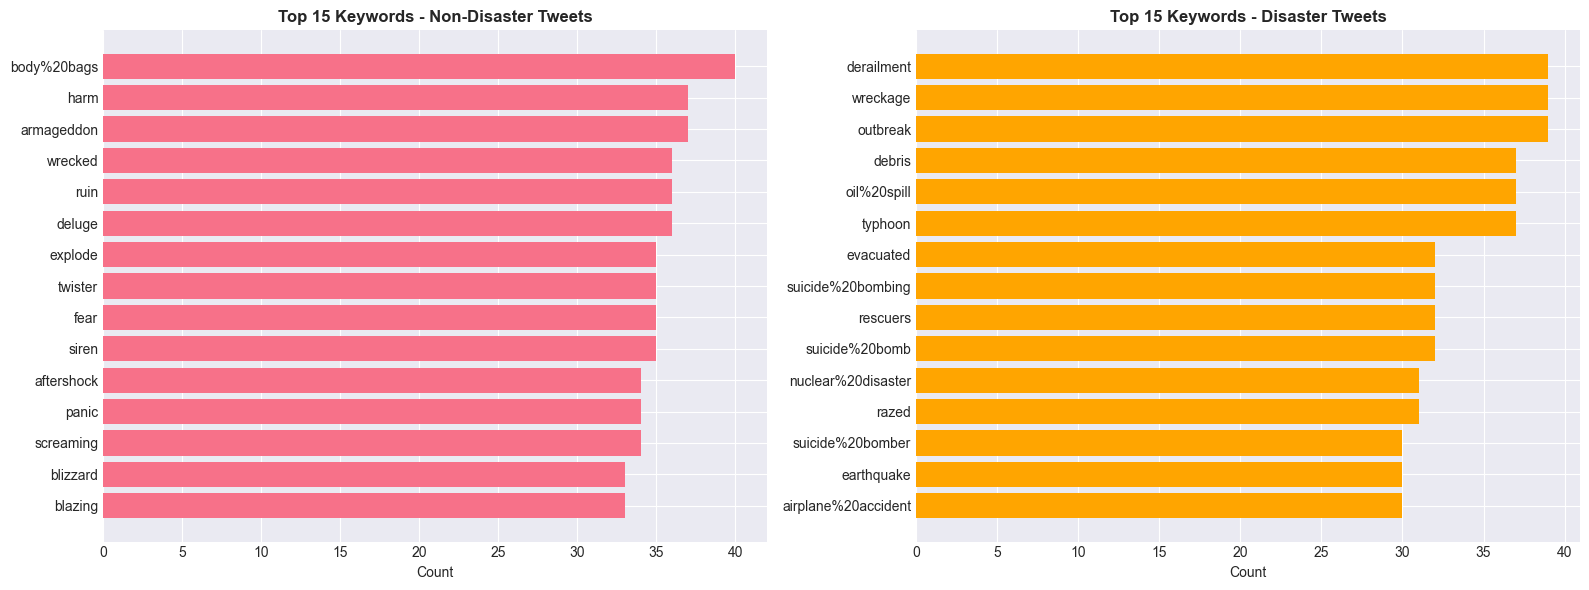

In [9]:
# Top keywords by target
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top keywords for non-disaster tweets
top_keywords_0 = train_df[train_df['target']==0]['keyword'].value_counts().head(15)
axes[0].barh(range(len(top_keywords_0)), top_keywords_0.values)
axes[0].set_yticks(range(len(top_keywords_0)))
axes[0].set_yticklabels(top_keywords_0.index)
axes[0].set_xlabel('Count')
axes[0].set_title('Top 15 Keywords - Non-Disaster Tweets', fontweight='bold')
axes[0].invert_yaxis()

# Top keywords for disaster tweets
top_keywords_1 = train_df[train_df['target']==1]['keyword'].value_counts().head(15)
axes[1].barh(range(len(top_keywords_1)), top_keywords_1.values, color='orange')
axes[1].set_yticks(range(len(top_keywords_1)))
axes[1].set_yticklabels(top_keywords_1.index)
axes[1].set_xlabel('Count')
axes[1].set_title('Top 15 Keywords - Disaster Tweets', fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 5. Text Preprocessing

In [10]:
# Text cleaning function
def clean_text(text):
    """
    Clean and preprocess text data
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply cleaning
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# Show examples
print("Original vs Cleaned Text Examples:\n")
for i in range(3):
    print(f"Original: {train_df['text'].iloc[i]}")
    print(f"Cleaned:  {train_df['cleaned_text'].iloc[i]}")
    print("-" * 80)

Original vs Cleaned Text Examples:

Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned:  our deeds are the reason of this earthquake may allah forgive us all
--------------------------------------------------------------------------------
Original: Forest fire near La Ronge Sask. Canada
Cleaned:  forest fire near la ronge sask canada
--------------------------------------------------------------------------------
Original: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Cleaned:  all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
--------------------------------------------------------------------------------


## 6. Word Frequency Analysis

In [11]:
# Get all words for each class
stop_words = set(stopwords.words('english'))

def get_words(df, target_value):
    words = []
    for text in df[df['target'] == target_value]['cleaned_text']:
        tokens = text.split()
        words.extend([word for word in tokens if word not in stop_words and len(word) > 2])
    return words

words_disaster = get_words(train_df, 1)
words_not_disaster = get_words(train_df, 0)

# Most common words
print("Top 20 words in DISASTER tweets:")
disaster_counter = Counter(words_disaster)
for word, count in disaster_counter.most_common(20):
    print(f"{word}: {count}")

print("\n" + "="*50 + "\n")

print("Top 20 words in NON-DISASTER tweets:")
not_disaster_counter = Counter(words_not_disaster)
for word, count in not_disaster_counter.most_common(20):
    print(f"{word}: {count}")

Top 20 words in DISASTER tweets:
fire: 178
news: 138
via: 121
disaster: 117
california: 111
suicide: 110
police: 107
amp: 107
people: 105
killed: 93
like: 92
hiroshima: 89
fires: 85
storm: 85
crash: 84
families: 81
train: 79
emergency: 76
buildings: 75
bomb: 74


Top 20 words in NON-DISASTER tweets:
like: 253
amp: 193
new: 168
get: 163
dont: 141
one: 128
body: 112
via: 99
would: 97
video: 96
people: 90
love: 89
know: 85
time: 84
back: 84
got: 83
see: 82
day: 81
cant: 81
emergency: 81


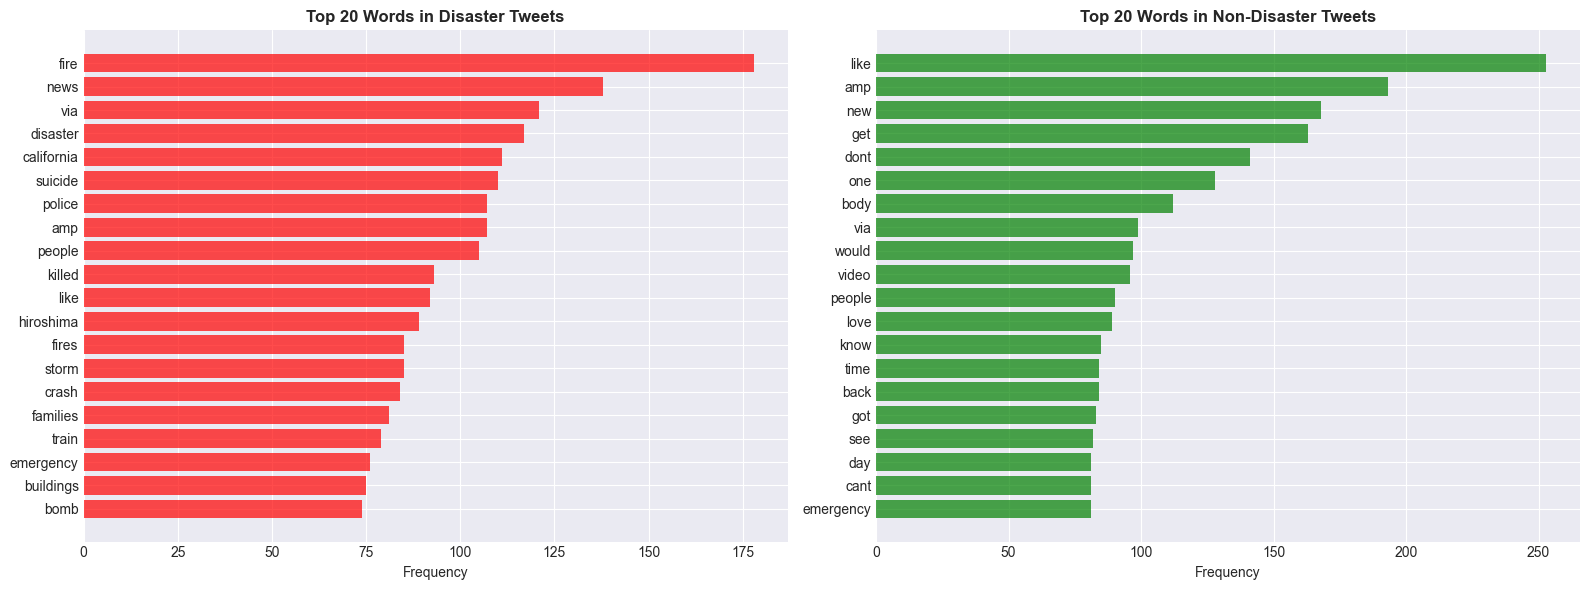

In [12]:
# Visualize top words
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top words for disaster tweets
top_disaster = dict(disaster_counter.most_common(20))
axes[0].barh(range(len(top_disaster)), list(top_disaster.values()), color='red', alpha=0.7)
axes[0].set_yticks(range(len(top_disaster)))
axes[0].set_yticklabels(list(top_disaster.keys()))
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 20 Words in Disaster Tweets', fontweight='bold')
axes[0].invert_yaxis()

# Top words for non-disaster tweets
top_not_disaster = dict(not_disaster_counter.most_common(20))
axes[1].barh(range(len(top_not_disaster)), list(top_not_disaster.values()), color='green', alpha=0.7)
axes[1].set_yticks(range(len(top_not_disaster)))
axes[1].set_yticklabels(list(top_not_disaster.keys()))
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 20 Words in Non-Disaster Tweets', fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## 7. Word Clouds

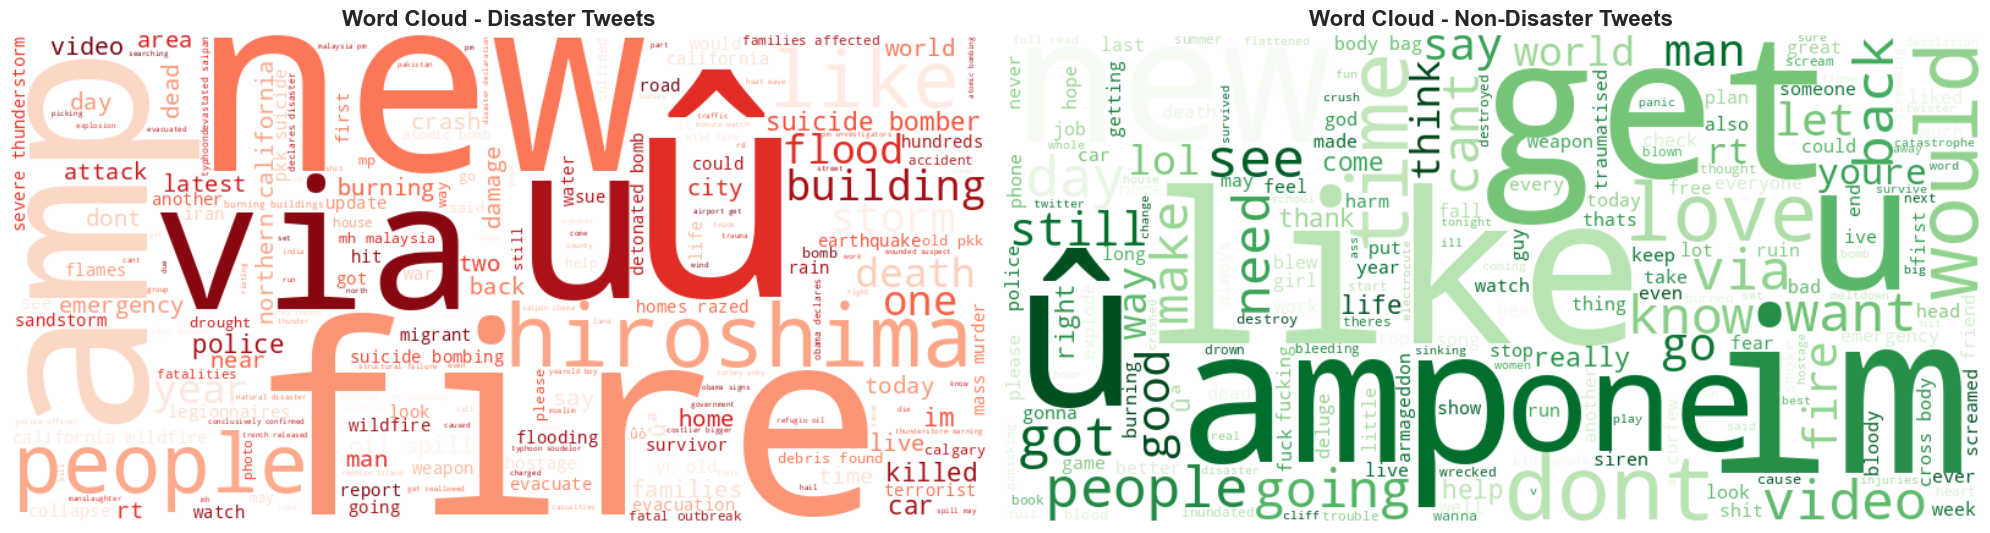

In [13]:
# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Word cloud for disaster tweets
disaster_text = ' '.join(train_df[train_df['target']==1]['cleaned_text'])
wordcloud_disaster = WordCloud(width=800, height=400, 
                                background_color='white',
                                colormap='Reds',
                                stopwords=stop_words).generate(disaster_text)

axes[0].imshow(wordcloud_disaster, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud - Disaster Tweets', fontsize=16, fontweight='bold')

# Word cloud for non-disaster tweets
not_disaster_text = ' '.join(train_df[train_df['target']==0]['cleaned_text'])
wordcloud_not_disaster = WordCloud(width=800, height=400,
                                    background_color='white',
                                    colormap='Greens',
                                    stopwords=stop_words).generate(not_disaster_text)

axes[1].imshow(wordcloud_not_disaster, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud - Non-Disaster Tweets', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Feature Engineering

In [14]:
# Create additional features
def create_features(df):
    """
    Create additional features from text
    """
    # Number of characters
    df['char_count'] = df['text'].apply(len)
    
    # Number of words
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    
    # Average word length
    df['avg_word_length'] = df['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
    
    # Number of stopwords
    df['stopwords_count'] = df['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in stop_words]))
    
    # Number of hashtags
    df['hashtag_count'] = df['text'].apply(lambda x: len([word for word in str(x).split() if word.startswith('#')]))
    
    # Number of mentions
    df['mention_count'] = df['text'].apply(lambda x: len([word for word in str(x).split() if word.startswith('@')]))
    
    # Number of URLs
    df['url_count'] = df['text'].apply(lambda x: len(re.findall(r'http\S+|www\S+|https\S+', str(x))))
    
    # Number of uppercase words
    df['uppercase_count'] = df['text'].apply(lambda x: len([word for word in str(x).split() if word.isupper() and len(word) > 1]))
    
    # Has keyword
    df['has_keyword'] = df['keyword'].notna().astype(int)
    
    # Has location
    df['has_location'] = df['location'].notna().astype(int)
    
    return df

# Apply feature engineering
train_df = create_features(train_df)
test_df = create_features(test_df)

# Display feature statistics
feature_cols = ['char_count', 'word_count', 'avg_word_length', 'stopwords_count', 
                'hashtag_count', 'mention_count', 'url_count', 'uppercase_count',
                'has_keyword', 'has_location']

print("Feature statistics by target:")
train_df.groupby('target')[feature_cols].mean()

Feature statistics by target:


,char_count,word_count,avg_word_length,stopwords_count,hashtag_count,mention_count,url_count,uppercase_count,has_keyword,has_location
target,,,,,,,,,,
0,95.706817,14.704744,5.871325,4.899585,0.385767,0.413404,0.508291,0.701981,0.995624,0.664210
1,108.113421,15.167533,6.469866,4.162641,0.509019,0.265668,0.770712,0.748089,0.987160,0.671354


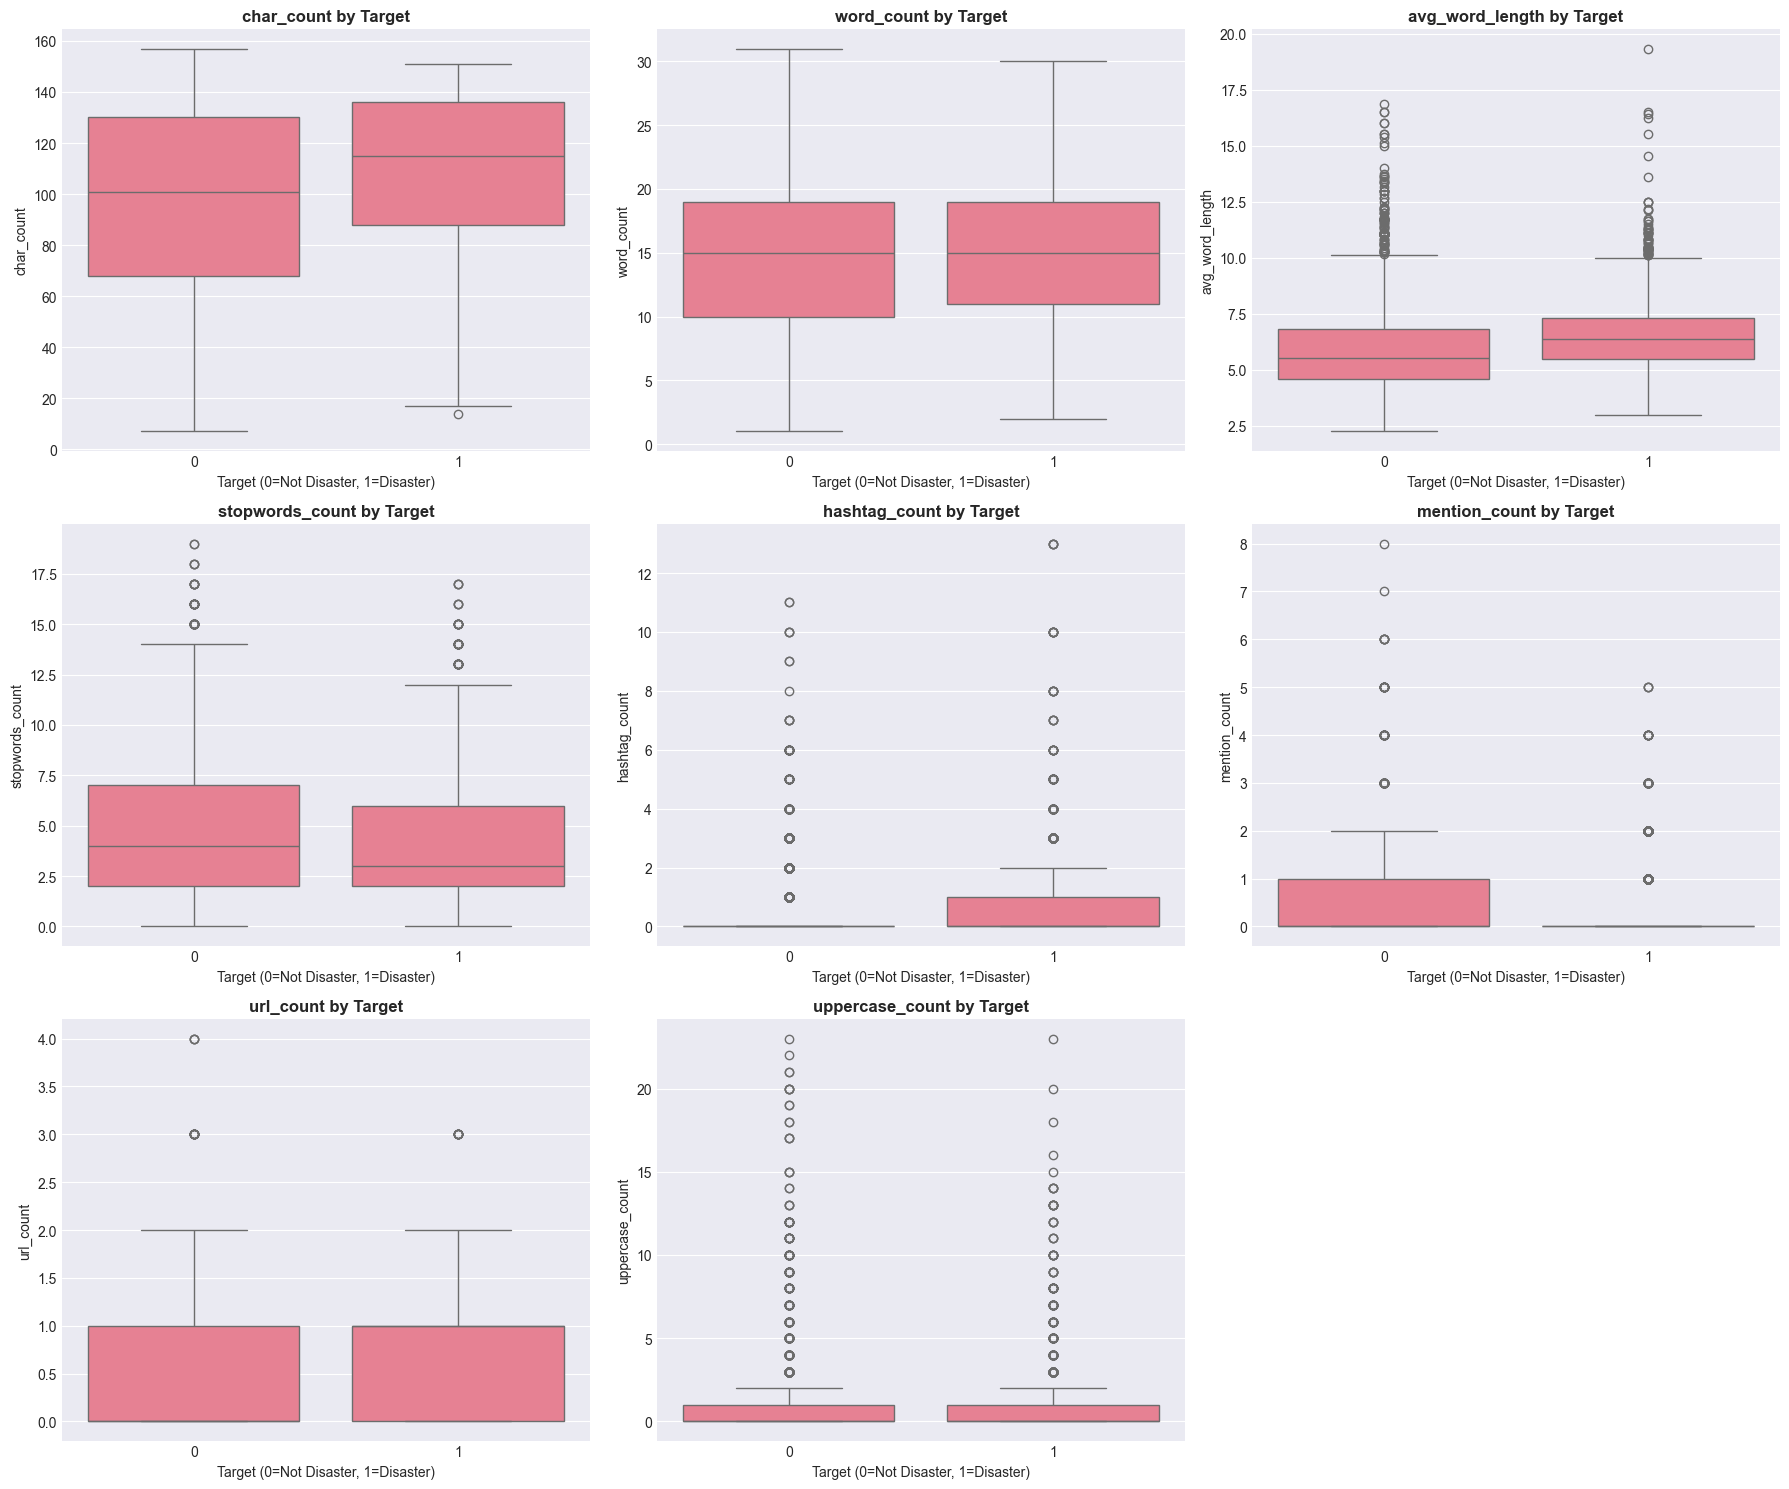

In [15]:
# Visualize feature distributions
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

numeric_features = ['char_count', 'word_count', 'avg_word_length', 'stopwords_count', 
                    'hashtag_count', 'mention_count', 'url_count', 'uppercase_count']

for idx, col in enumerate(numeric_features):
    sns.boxplot(data=train_df, x='target', y=col, ax=axes[idx])
    axes[idx].set_title(f'{col} by Target', fontweight='bold')
    axes[idx].set_xlabel('Target (0=Not Disaster, 1=Disaster)')

# Remove the last subplot
fig.delaxes(axes[8])

plt.tight_layout()
plt.show()

## 9. Feature Correlation

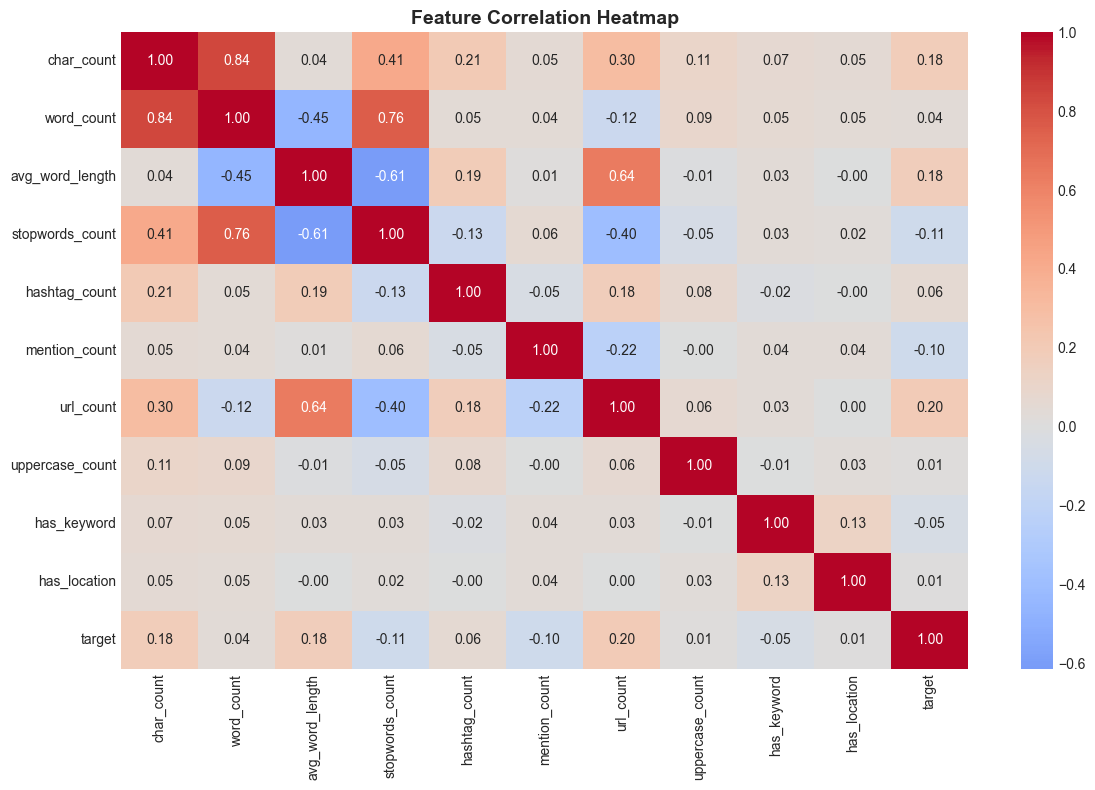


Features correlation with target (sorted):
target             1.000000
url_count          0.195607
char_count         0.181817
avg_word_length    0.176855
hashtag_count      0.055989
word_count         0.039966
uppercase_count    0.011934
has_location       0.007506
has_keyword       -0.046998
mention_count     -0.103873
stopwords_count   -0.105374
Name: target, dtype: float64


In [16]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_features = feature_cols + ['target']
correlation_matrix = train_df[correlation_features].corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Features most correlated with target
print("\nFeatures correlation with target (sorted):")
print(correlation_matrix['target'].sort_values(ascending=False))

## 10. Baseline Models

Let's build some baseline models using TF-IDF vectorization.

In [17]:
# Prepare data for modeling
X = train_df['cleaned_text']
y = train_df['target']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"\nTarget distribution in train set:")
print(y_train.value_counts(normalize=True))
print(f"\nTarget distribution in validation set:")
print(y_val.value_counts(normalize=True))

Training set size: 6090
Validation set size: 1523

Target distribution in train set:
target
0    0.570279
1    0.429721
Name: proportion, dtype: float64

Target distribution in validation set:
target
0    0.570584
1    0.429416
Name: proportion, dtype: float64


In [18]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Number of features: {len(tfidf.get_feature_names_out())}")

TF-IDF matrix shape: (6090, 5000)
Number of features: 5000


In [19]:
# Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

lr_pred = lr_model.predict(X_val_tfidf)
lr_accuracy = accuracy_score(y_val, lr_pred)
lr_f1 = f1_score(y_val, lr_pred)

print(f"\nLogistic Regression Results:")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"F1 Score: {lr_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, lr_pred, target_names=['Not Disaster', 'Disaster']))

Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.8162
F1 Score: 0.7682

Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.80      0.90      0.85       869
    Disaster       0.84      0.71      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



In [20]:
# Naive Bayes
print("Training Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

nb_pred = nb_model.predict(X_val_tfidf)
nb_accuracy = accuracy_score(y_val, nb_pred)
nb_f1 = f1_score(y_val, nb_pred)

print(f"\nNaive Bayes Results:")
print(f"Accuracy: {nb_accuracy:.4f}")
print(f"F1 Score: {nb_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, nb_pred, target_names=['Not Disaster', 'Disaster']))

Training Naive Bayes...

Naive Bayes Results:
Accuracy: 0.8122
F1 Score: 0.7500

Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.78      0.93      0.85       869
    Disaster       0.88      0.66      0.75       654

    accuracy                           0.81      1523
   macro avg       0.83      0.79      0.80      1523
weighted avg       0.82      0.81      0.81      1523



In [21]:
# Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)

rf_pred = rf_model.predict(X_val_tfidf)
rf_accuracy = accuracy_score(y_val, rf_pred)
rf_f1 = f1_score(y_val, rf_pred)

print(f"\nRandom Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, rf_pred, target_names=['Not Disaster', 'Disaster']))

Training Random Forest...

Random Forest Results:
Accuracy: 0.7978
F1 Score: 0.7412

Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.78      0.89      0.83       869
    Disaster       0.82      0.67      0.74       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523




Model Comparison:
              Model  Accuracy  F1 Score
Logistic Regression  0.816152  0.768212
        Naive Bayes  0.812213  0.750000
      Random Forest  0.797768  0.741176


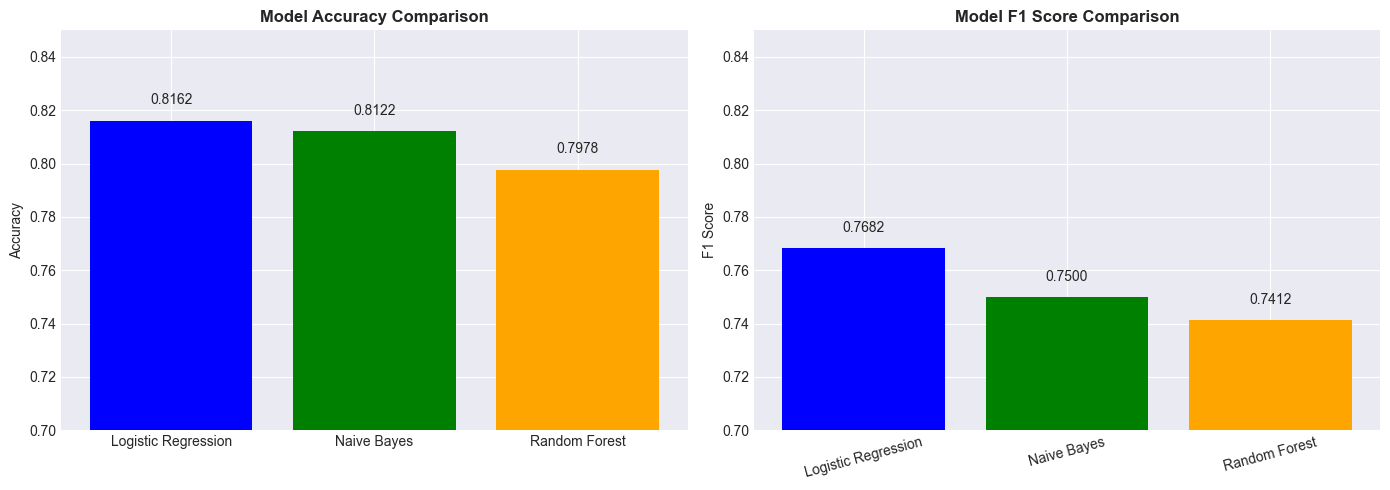

In [22]:
# Compare models
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest'],
    'Accuracy': [lr_accuracy, nb_accuracy, rf_accuracy],
    'F1 Score': [lr_f1, nb_f1, rf_f1]
})

print("\nModel Comparison:")
print(results_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
axes[0].bar(results_df['Model'], results_df['Accuracy'], color=['blue', 'green', 'orange'])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0].set_ylim([0.7, 0.85])
for i, v in enumerate(results_df['Accuracy']):
    axes[0].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom')

# F1 Score comparison
axes[1].bar(results_df['Model'], results_df['F1 Score'], color=['blue', 'green', 'orange'])
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Model F1 Score Comparison', fontweight='bold')
axes[1].set_ylim([0.7, 0.85])
for i, v in enumerate(results_df['F1 Score']):
    axes[1].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom')

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

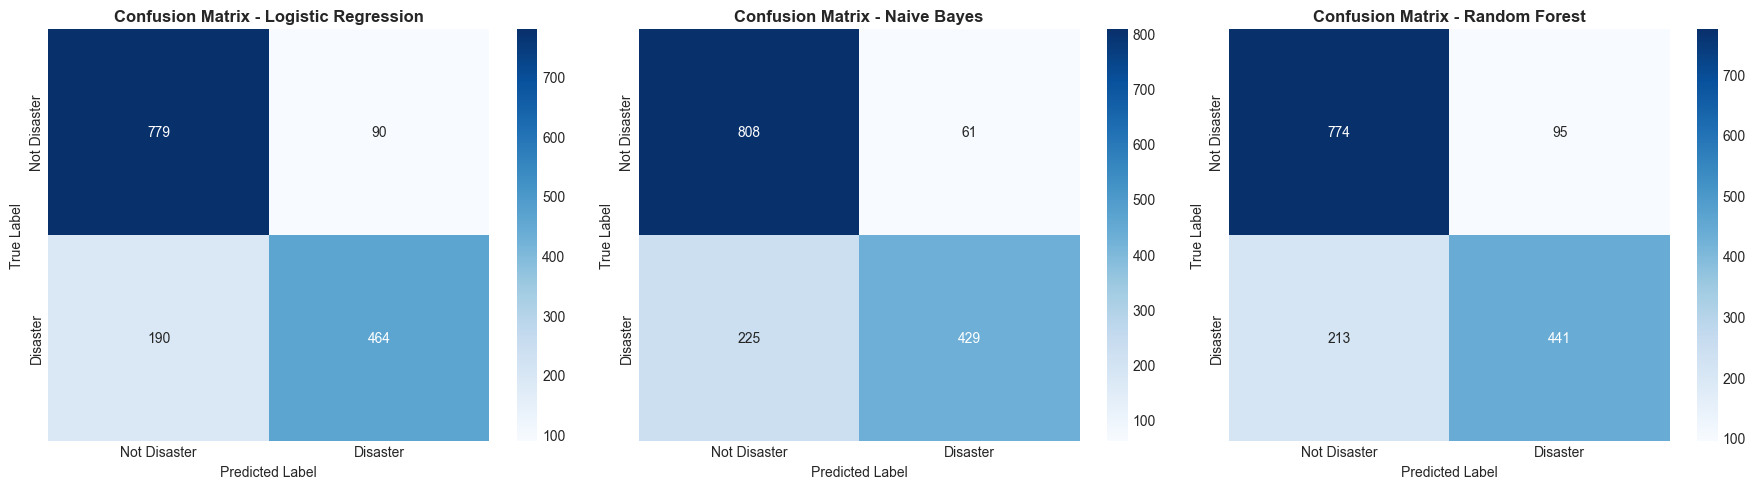

In [23]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_pred = [
    ('Logistic Regression', lr_pred),
    ('Naive Bayes', nb_pred),
    ('Random Forest', rf_pred)
]

for idx, (name, pred) in enumerate(models_pred):
    cm = confusion_matrix(y_val, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'Confusion Matrix - {name}', fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')
    axes[idx].set_xticklabels(['Not Disaster', 'Disaster'])
    axes[idx].set_yticklabels(['Not Disaster', 'Disaster'])

plt.tight_layout()
plt.show()

## 11. Feature Importance Analysis

In [24]:
# Get feature importance from Logistic Regression coefficients
feature_names = tfidf.get_feature_names_out()
coefficients = lr_model.coef_[0]

# Top positive coefficients (disaster indicators)
top_positive_idx = np.argsort(coefficients)[-20:]
top_positive_features = [(feature_names[i], coefficients[i]) for i in top_positive_idx]

# Top negative coefficients (non-disaster indicators)
top_negative_idx = np.argsort(coefficients)[:20]
top_negative_features = [(feature_names[i], coefficients[i]) for i in top_negative_idx]

print("Top 20 Disaster Indicators (words/phrases):")
for feature, coef in reversed(top_positive_features):
    print(f"{feature}: {coef:.4f}")

print("\n" + "="*50 + "\n")

print("Top 20 Non-Disaster Indicators (words/phrases):")
for feature, coef in top_negative_features:
    print(f"{feature}: {coef:.4f}")

Top 20 Disaster Indicators (words/phrases):
hiroshima: 3.2222
in: 2.9175
fires: 2.5837
california: 2.4461
wildfire: 2.4004
storm: 2.3681
fire: 2.2574
train: 2.2072
suicide: 2.1284
floods: 2.0767
accident: 2.0153
killed: 1.9940
earthquake: 1.9588
bombing: 1.9378
massacre: 1.9272
near: 1.8657
police: 1.8338
attack: 1.7390
buildings: 1.7349
mass: 1.6898


Top 20 Non-Disaster Indicators (words/phrases):
you: -3.5295
my: -2.9086
new: -2.0636
im: -1.9651
love: -1.8267
full: -1.5411
or: -1.5359
body: -1.4485
hes: -1.4199
bloody: -1.4010
wrecked: -1.3916
harm: -1.3857
upheaval: -1.3837
nowplaying: -1.3156
all: -1.2739
bags: -1.2717
let: -1.2553
demolish: -1.2435
me: -1.2369
crushed: -1.2029


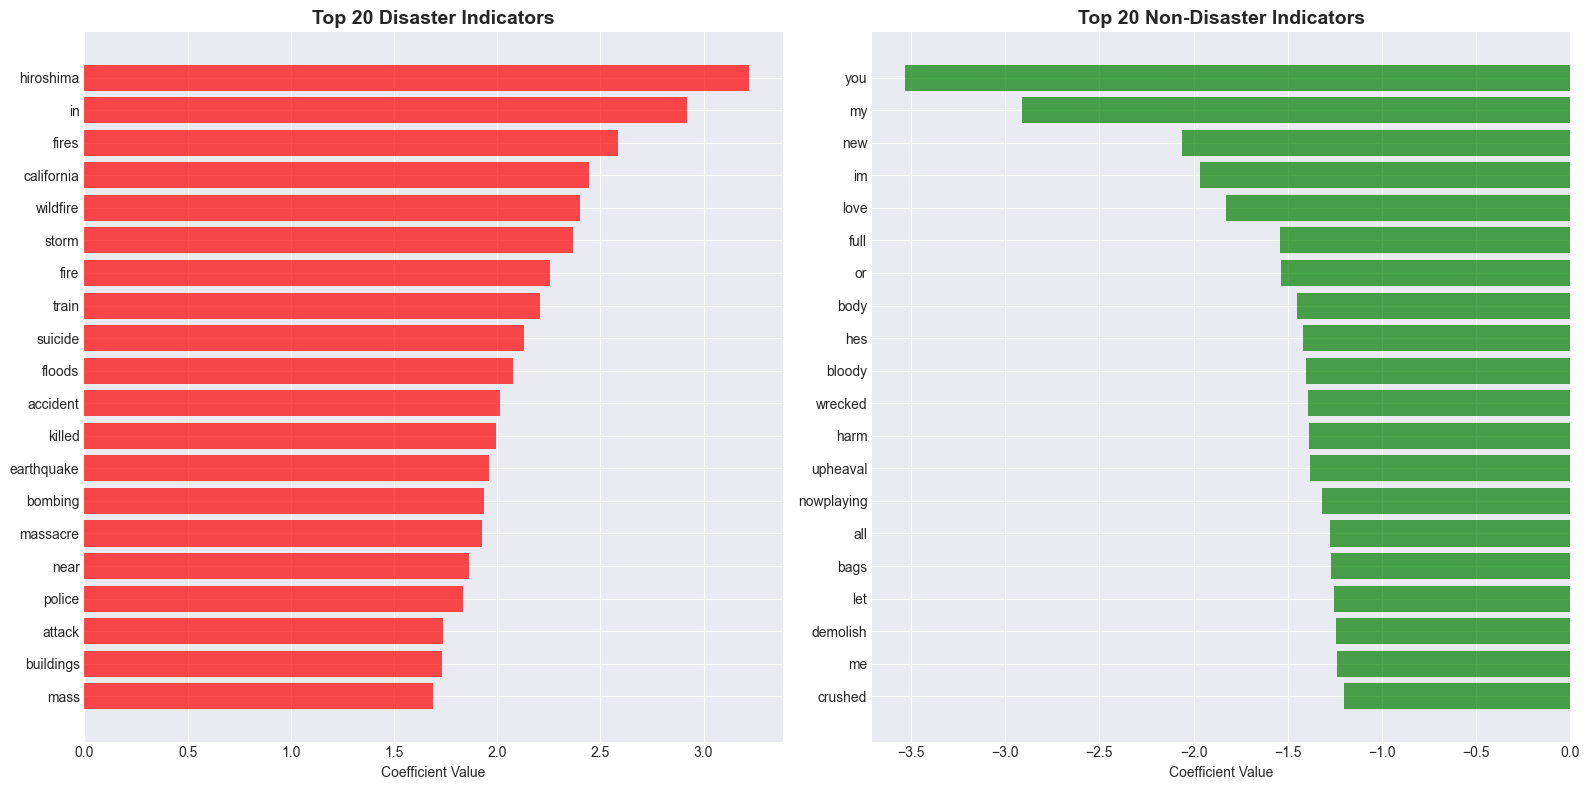

In [25]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Disaster indicators
features_pos = [f[0] for f in reversed(top_positive_features)]
coefs_pos = [f[1] for f in reversed(top_positive_features)]

axes[0].barh(range(len(features_pos)), coefs_pos, color='red', alpha=0.7)
axes[0].set_yticks(range(len(features_pos)))
axes[0].set_yticklabels(features_pos)
axes[0].set_xlabel('Coefficient Value')
axes[0].set_title('Top 20 Disaster Indicators', fontweight='bold', fontsize=14)
axes[0].invert_yaxis()

# Non-disaster indicators
features_neg = [f[0] for f in top_negative_features]
coefs_neg = [f[1] for f in top_negative_features]

axes[1].barh(range(len(features_neg)), coefs_neg, color='green', alpha=0.7)
axes[1].set_yticks(range(len(features_neg)))
axes[1].set_yticklabels(features_neg)
axes[1].set_xlabel('Coefficient Value')
axes[1].set_title('Top 20 Non-Disaster Indicators', fontweight='bold', fontsize=14)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()